In [17]:
%matplotlib inline
import pandas as pd
import math
from numpy import nan
import re
import plfit
from matplotlib.ticker import NullFormatter 

from pylab import scatter
import pylab
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from scipy import stats 

font = {'family' : 'Helvetica',
        'size'   : 16}

matplotlib.rc('font', **font)

stat_cols = [
    'id',
    'tree_depth',
    'color_count',
    'individuations',
    'prunings',
    'initial_color_count',
    'adjacent_nodes',
    'initial_coloring_runtime',
    'triple_count',
    'graph_digest',
    'to_hash_runtime',
    'canonicalize_triples_runtime',
    'error',
    ]

data = pd.read_csv("results.csv", header=None, names=stat_cols)

data.head()

,id,tree_depth,color_count,individuations,prunings,initial_color_count,adjacent_nodes,initial_coloring_runtime,triple_count,graph_digest,to_hash_runtime,canonicalize_triples_runtime,error
0,http://data.deutsche-biographie.de/Person/sfz99,0,0,0,NaN,0,0,0.000223,30,db54379b01b2e7cfb8fb9aa9f01c6caf09b7ab6d6b5245...,0.000794,0.000232,NaN
1,http://www.eionet.europa.eu/gemet/2004/06/geme...,0,0,0,NaN,0,0,0.000212,33,11cff7a1d3343d1c4db7c5ff739d7a48ecb616c521ead4...,0.000946,0.000219,NaN
2,http://ontologi.es/colour/vocab,0,0,0,NaN,0,0,0.000036,1,269c803cdb503fad661e7de78b03f9b256579aca99a63d...,0.000092,0.000043,NaN
3,http://lod.hebis.de/data/06073998,0,2,0,NaN,2,1,0.000067,1,a4b485834683f9994a1d1eabdfbd8b2a1bff7be1dd4255...,0.000137,0.000085,NaN
4,http://keithalexander.co.uk/pbac/,0,0,0,NaN,0,0,0.000035,1,e421bdceca0293aa919f2b44ddbef1922cc4e7765801e3...,0.000092,0.000043,NaN


In [12]:
data['error'] = data['error'].apply(lambda x: 
                                    re.sub(".+?apikey=([0-9a-z]+[-]?)+","",x) 
                                    if isinstance(x,str) else x)
failures = data[data['error'].apply(type) == str]
successes = data[data['error'].apply(type) != str]

def get_log_bins(values, bin_count):
    bins = [math.log10(min(values)),math.log10(max(values))]
    bins = map(lambda x: (bins[1]-bins[0])*x/float(bin_count)+bins[0], range(bin_count))
    bins = map(lambda x: 10**x, bins)    
    return bins

def plot_power_law(x, y, xlabel, ylabel, color="blue", **kwargs):
    fig = plt.figure(1, figsize=(16, 16), dpi=150 )
    nullfmt   = NullFormatter()         # no labels
    
    left, width = 0.1, 0.9
    bottom, height = 0.1, 0.9
    bottom_h = left_h = left+width+0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.1, height]

    ax = plt.axes(rect_scatter)
    ax.scatter(x ,y , c=color, s=64, alpha=0.75)
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_ylabel(ylabel)
    xx = x.apply(math.log10)
    yy = y.apply(math.log10)
    
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(xx, yy)
    
    a = 10**intercept
    b = slope
    predict_y = intercept + slope * xx
    pred_error = yy - predict_y
    degrees_of_freedom = len(xx) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)

    pylab.plot(x, 10**predict_y, 'k-', label="Best fit")
    
    
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    axHistx.set_xscale('log')
    axHistx.set_xlim( ax.get_xlim() ) 
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHistx.hist(list(x), get_log_bins(x, 30), facecolor='green', alpha=0.75)

    axHisty.set_yscale('log')
    axHisty.set_ylim( ax.get_ylim() ) 
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHisty.hist(list(y), get_log_bins(y, 30), facecolor='green', alpha=0.75, orientation='horizontal' )

    #print get_log_bins(y, 50)
    
    pylab.show()
    print "r =", r_value
    print "p =", p_value
    print 10**intercept, slope
    print "y = %.6f * x^%-.6f"%(a,b)

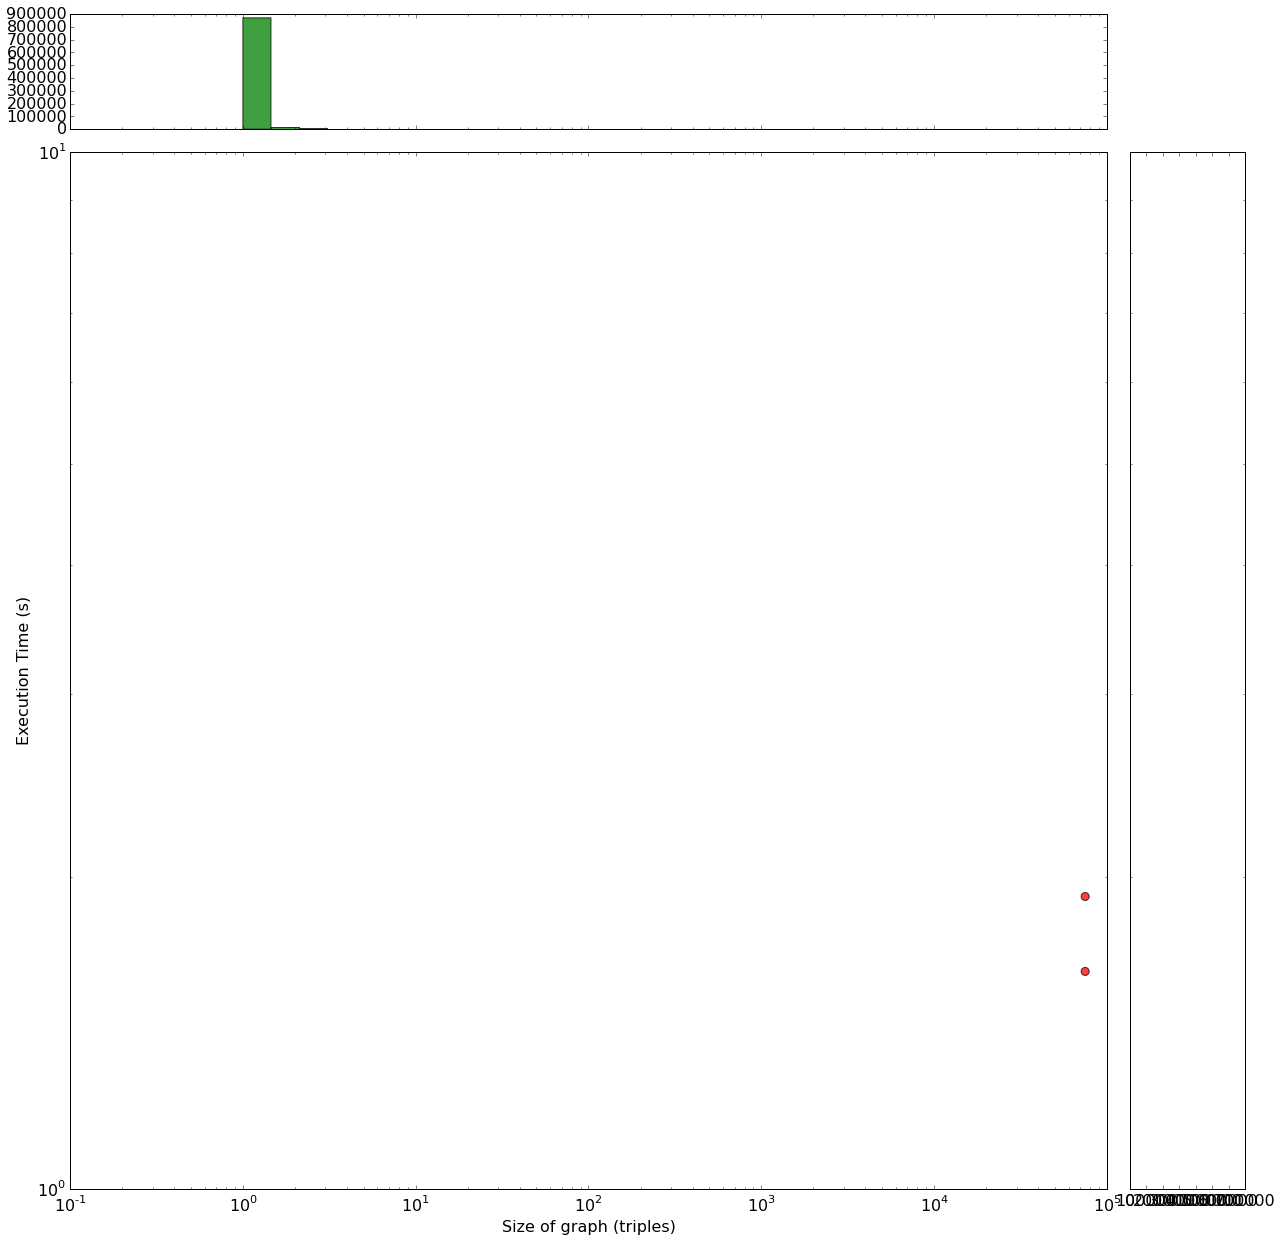

r = nan
p = nan
nan nan
y = nan * x^nan


In [13]:
by_triples = data[data['triple_count'] > 0].sort(columns=['triple_count'])

color = by_triples.apply(lambda x:  "red" if x['color_count'] == 0 
                         else ("yellow" if x['tree_depth'] > 0 
                               else 'blue'), axis=1)

plot_power_law(by_triples['triple_count'], by_triples['to_hash_runtime'], color=color,
               xlabel="Size of graph (triples)", ylabel="Execution Time (s)")


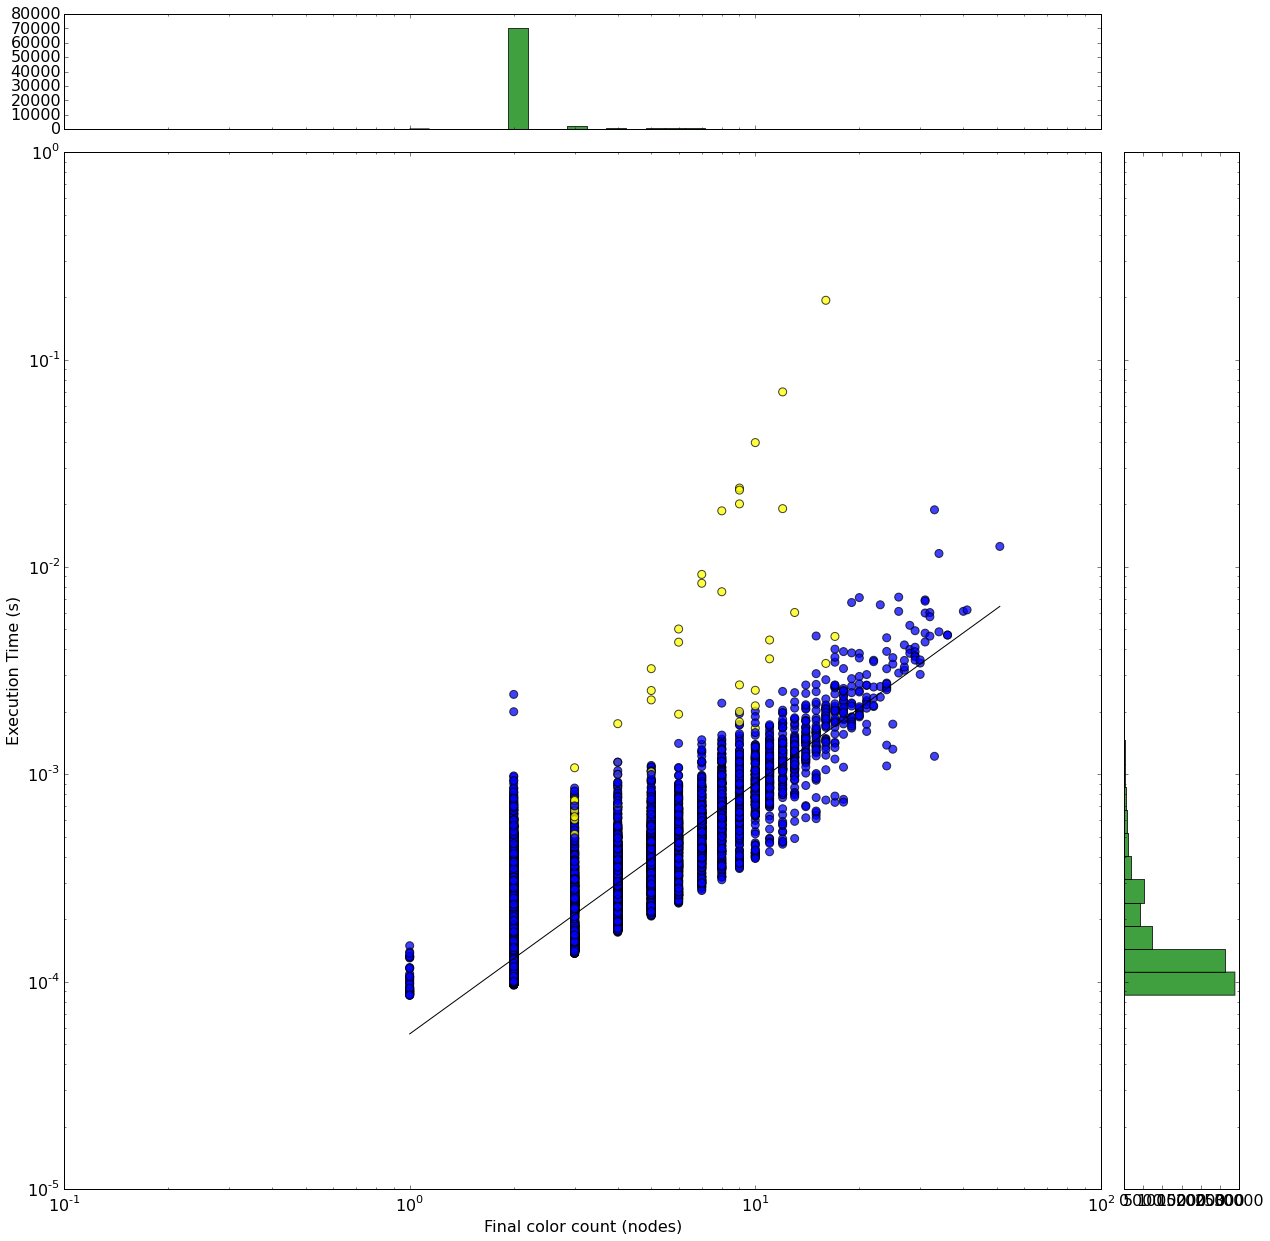

r = 0.750941938354
p = 0.0
5.59663782823e-05 1.20740661248
y = 0.000056 * x^1.207407


In [14]:
has_bnodes = data[data['color_count'] > 0]
has_bnodes = has_bnodes.sort(columns=["color_count"])

color = has_bnodes.apply(lambda x:  "yellow" if x['tree_depth'] > 0 else 'blue', axis=1)
plot_power_law(has_bnodes['color_count'], has_bnodes['to_hash_runtime'], color=color,
               xlabel = "Final color count (nodes)", ylabel="Execution Time (s)")

ValueError: math domain error

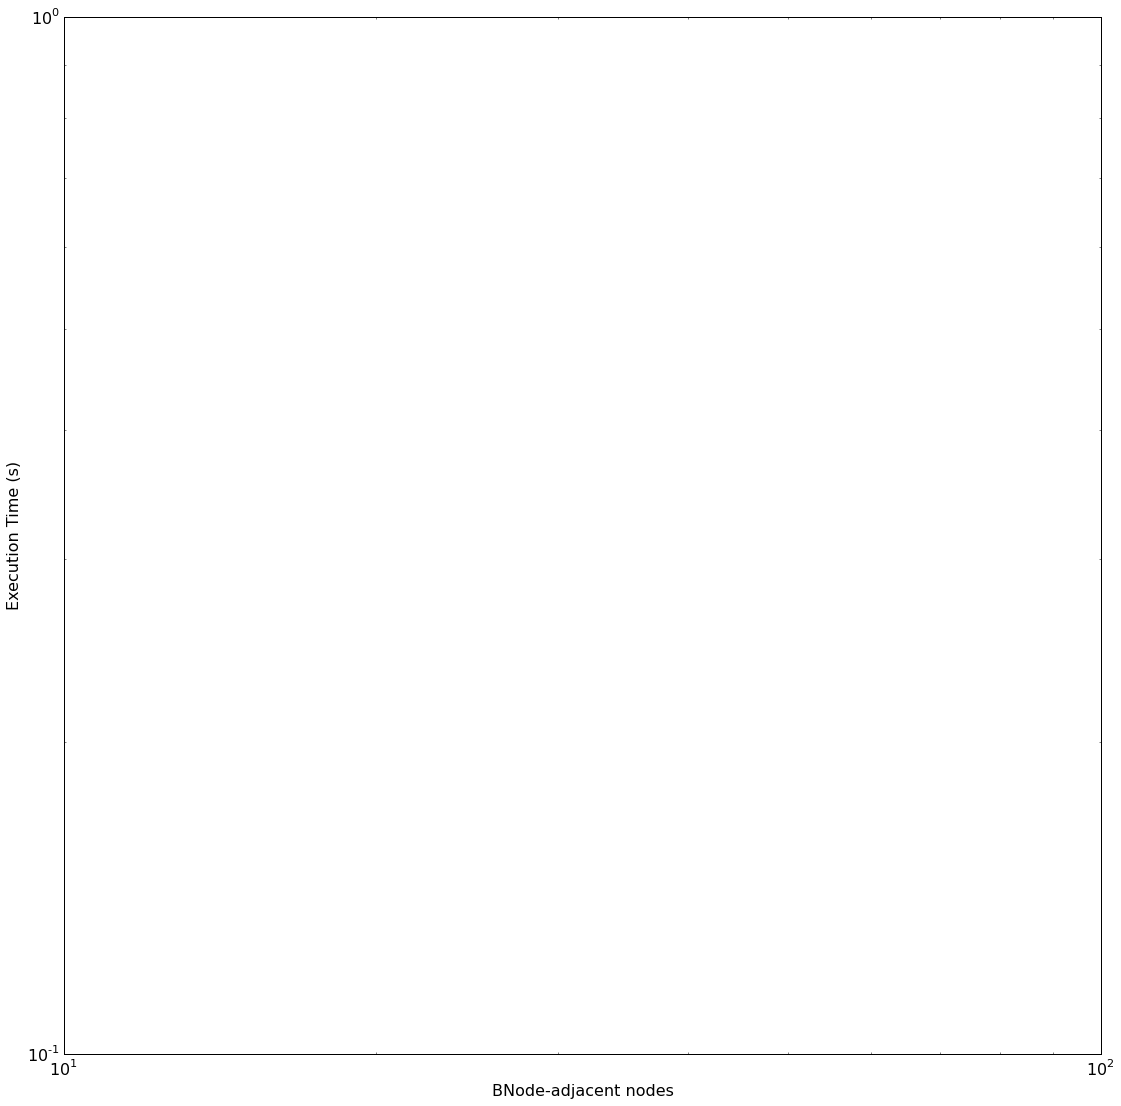

In [15]:
has_bnodes = data[data['color_count'] > 0]
has_bnodes = has_bnodes.sort(columns=["color_count"])

color = has_bnodes.apply(lambda x:  "yellow" if x['tree_depth'] > 0 else 'blue', axis=1)
plot_power_law(has_bnodes['adjacent_nodes'], has_bnodes['to_hash_runtime'], color=color,
               xlabel = "BNode-adjacent nodes", ylabel="Execution Time (s)")

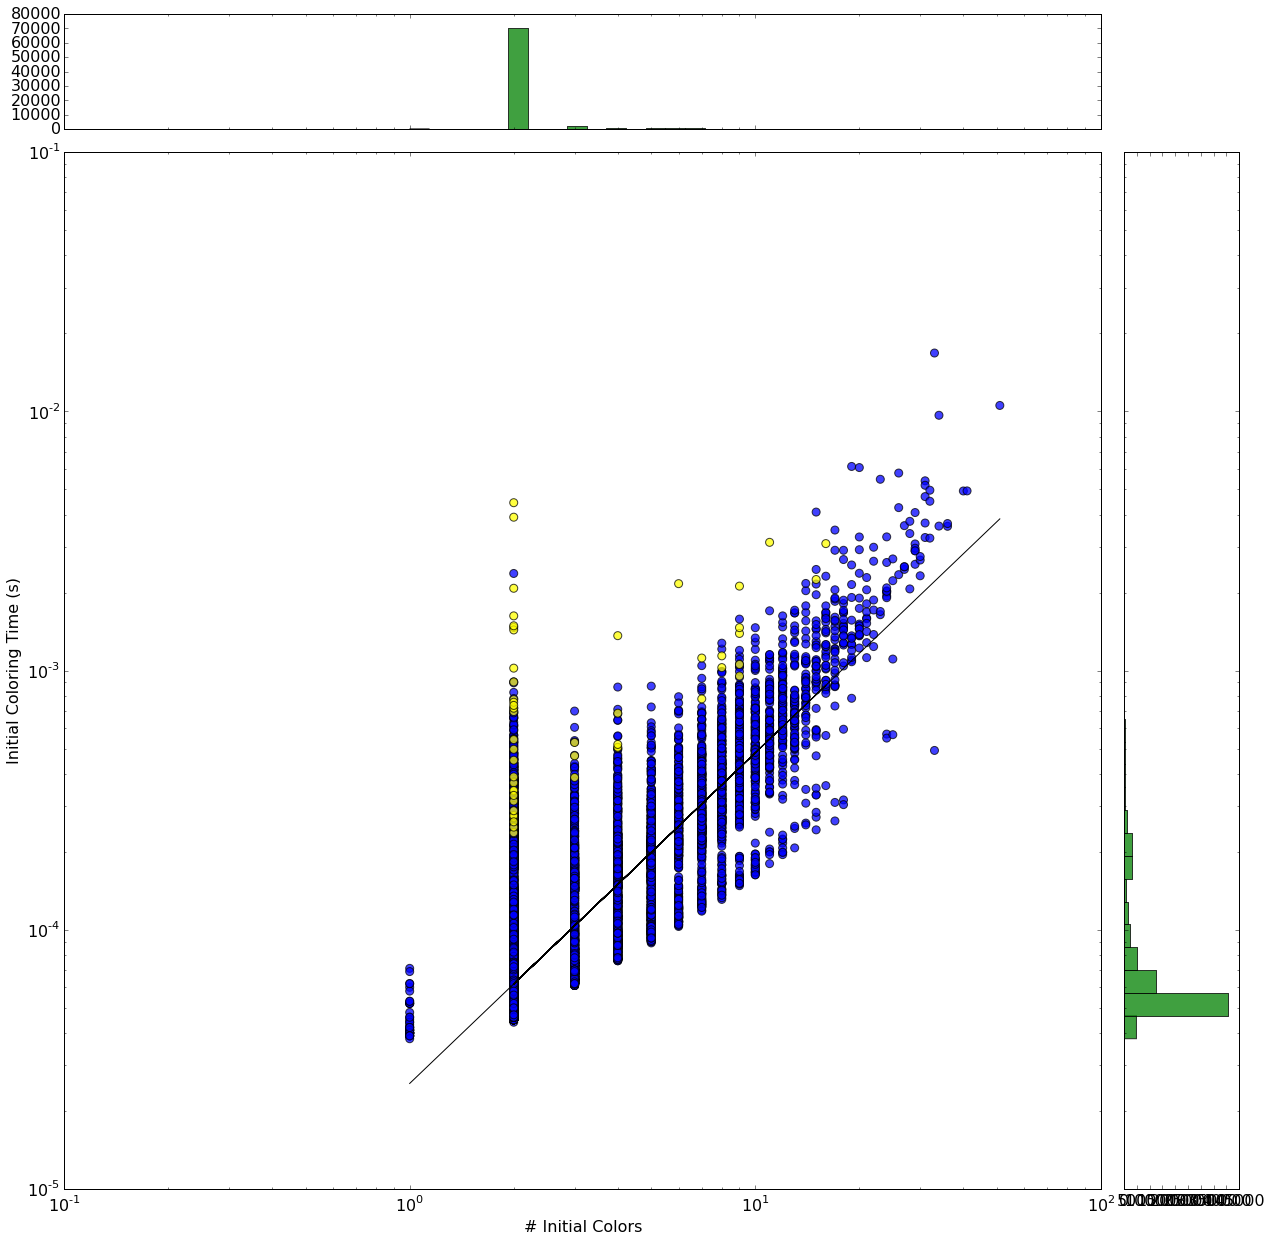

r = 0.669226772142
p = 0.0
2.55394794216e-05 1.2755492609
y = 0.000026 * x^1.275549


In [16]:
has_bnodes = data[data['color_count'] > 0]
has_bnodes = has_bnodes.sort(columns=["color_count"])

color = has_bnodes.apply(lambda x:  "yellow" if x['tree_depth'] > 0 else 'blue', axis=1)
plot_power_law(has_bnodes['initial_color_count'], has_bnodes['initial_coloring_runtime'], color=color,
               xlabel = "# Initial Colors", ylabel="Initial Coloring Time (s)")

[0.6989700043360189, 5.681665372101854]
[0.6989700043360189, 0.7986239116913356, 0.8982778190466523, 0.9979317264019689, 1.0975856337572858, 1.1972395411126024, 1.296893448467919, 1.3965473558232357, 1.4962012631785524, 1.595855170533869, 1.695509077889186, 1.7951629852445028, 1.8948168925998194, 1.994470799955136, 2.0941247073104527, 2.1937786146657694, 2.293432522021086, 2.393086429376403, 2.4927403367317194, 2.592394244087036, 2.692048151442353, 2.7917020587976697, 2.8913559661529864, 2.9910098735083026, 3.0906637808636197, 3.1903176882189364, 3.2899715955742534, 3.3896255029295697, 3.4892794102848863, 3.5889333176402034, 3.6885872249955196, 3.7882411323508363, 3.8878950397061534, 3.98754894706147, 4.0872028544167875, 4.186856761772104, 4.28651066912742, 4.386164576482737, 4.485818483838053, 4.58547239119337, 4.6851262985486875, 4.784780205904004, 4.884434113259321, 4.984088020614637, 5.083741927969954, 5.18339583532527, 5.2830497426805865, 5.382703650035904, 5.482357557391221, 5.58

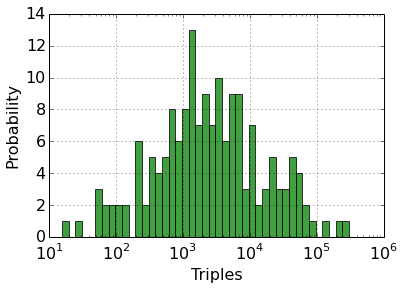

In [82]:
import matplotlib.mlab as mlab


x = list(by_triples['triple_count'])

fig = plt.figure()
ax = fig.add_subplot(111)
bins = [math.log10(min(x)),math.log10(max(x))]
print bins
bins = map(lambda x: (bins[1]-bins[0])*x/50.0+bins[0], range(50))
print bins
bins = map(lambda x: 10**x, bins)
print bins

ax.set_xscale('log')
# the histogram of the data
n, bins, patches = ax.hist(x, bins, facecolor='green', alpha=0.75)

# hist uses np.histogram under the hood to create 'n' and 'bins'.
# np.histogram returns the bin edges, so there will be 50 probability
# density values in n, 51 bin edges in bins and 50 patches.  To get
# everything lined up, we'll compute the bin centers
bincenters = 0.5*(bins[1:]+bins[:-1])
# add a 'best fit' line for the normal PDF

ax.set_xlabel('Triples')
ax.set_ylabel('Probability')
#ax.set_title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
#ax.set_xlim(40, 160)
#ax.set_ylim(0, 0.03)
ax.grid(True)

plt.show()

In [32]:
has_bnodes['initial_color_count']

112     2
95      6
175     5
274    10
308    12
96     12
221    13
204    16
91     16
311    25
325    25
113    27
41     31
316    33
153    33
...
198     2788
288     2816
148     2969
179     3935
181     4048
192     4311
259     5161
201     6048
218     6105
257     8127
245    10525
196    12166
317    12402
331    12955
279    17972
Name: initial_color_count, Length: 121, dtype: float64

In [49]:
range

3.9535664142570068

In [83]:
len(successes)

170